In [1]:
import numpy as np
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0' ## please on a machine with GPU
os.chdir(r'./..')
import sys
sys.path.append('.')
import torch
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cudnn.deterministic = True
from diffuser.guides.policies import Policy
import diffuser.datasets as datasets
import diffuser.utils as utils
from diffuser.models import GaussianDiffusionPB
from diffuser.guides.policies_compose import PolicyCompose
from datetime import datetime
import os.path as osp
from tqdm import tqdm
from diffuser.utils.jupyter_utils import suppress_stdout

## You need to download 'maze2d-static1-base' from OneDrive Link in README.md to launch
class Parser(utils.Parser):
    config: str = "config/rm2d/rSmaze_nw6_hExt05_exp.py"

#---------------------------------- setup ----------------------------------#

## training args
args_train = Parser().parse_args('diffusion', from_jupyter=True)
args = Parser().parse_args('plan', from_jupyter=True)

args.savepath = None # osp.join(args.savepath, sub_dir)
args.load_unseen_maze = True

## load dataset here, dataset is a string: name of the env
print('args.dataset', type(args.dataset), args.dataset)
print('args.dataset_eval', type(args.dataset_eval), args.dataset_eval)
use_normed_wallLoc = args_train.dataset_config.get('use_normed_wallLoc', False)

## use the trained env or eval env
load_unseen_maze = True # args.load_unseen_maze # True False
with suppress_stdout():
    #---------------------------------- loading ----------------------------------#
    from pb_diff_envs.environment.static.maze2d_rand_wgrp_43 import RandRectangleGroup_43
    train_env_list: RandRectangleGroup_43
    train_env_list = datasets.load_environment(args.dataset, is_eval=load_unseen_maze)
    train_normalizer = utils.load_datasetNormalizer(train_env_list.dataset_url, args_train, train_env_list)

    ld_config = dict(env_instance=train_env_list) 
    diffusion_experiment = utils.load_potential_diffusion_model(args.logbase, args.dataset, \
                args_train.exp_name, epoch=args.diffusion_epoch, ld_config=ld_config)
    diffusion = diffusion_experiment.ema

pybullet build time: May 20 2022 19:45:31


module <module 'rSmaze_nw6_hExt05_exp' from '/home/hongli/YankunWEI/potential-motion-plan-release/config/rm2d/rSmaze_nw6_hExt05_exp.py'>
[ utils/setup ] Reading config: config/rm2d/rSmaze_nw6_hExt05_exp:randSmaze2d_ng3ks25k_ms55nw6_hExt05_v0
[ utils/setup ] Not using overrides | config: config/rm2d/rSmaze_nw6_hExt05_exp | dataset: randSmaze2d_ng3ks25k_ms55nw6_hExt05_v0
prefix  diffusion/
config_fn rSmaze_nw6_hExt05_exp 
horizon H 48
n_diffusion_steps T 100
exp_name diffusion/rSmaze_nw6_hExt05_exp_H48_T100
[ utils/setup ] Setting exp_name to: diffusion/rSmaze_nw6_hExt05_exp_H48_T100
[ utils/setup ] Saved args to logs/randSmaze2d-ng3ks25k-ms55nw6-hExt05-v0/diffusion/rSmaze_nw6_hExt05_exp_H48_T100/args.json
module <module 'rSmaze_nw6_hExt05_exp' from '/home/hongli/YankunWEI/potential-motion-plan-release/config/rm2d/rSmaze_nw6_hExt05_exp.py'>
[ utils/setup ] Reading config: config/rm2d/rSmaze_nw6_hExt05_exp:randSmaze2d_ng3ks25k_ms55nw6_hExt05_v0
[ utils/setup ] Not using overrides | config

/home/hongli/anaconda3/envs/motion/lib/python3.9/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [2]:
from diffuser.utils.rm2d_render import RandStaticMazeRenderer
import imageio
np.set_printoptions(precision=3)
## define an env's wall locations
# wloc_source = 'from_env'
wloc_source = 'from_env'
if wloc_source == 'from_env':
    env_id = 17
    wloc = train_env_list.wallLoc_list[env_id]
    print(f'wall locations of env {env_id}:')
    print(train_env_list.wallLoc_list[env_id])
elif wloc_source == 'user_input':
    env_id = 5 # placholder
    wloc = np.array([
        [0.983, 1.844],
        [1.444, 3.904],
        [2.32,  1.612],
        [3.495, 0.713],
        [3.9,   4.307],
        [4.107, 2.546],])

    ## wall size must be fixed
    train_env_list.create_env_by_pos(env_id, wloc, train_env_list.hExt_list[env_id])

wall locations of env 17:
[[0.908 3.01 ]
 [1.07  0.768]
 [2.335 1.975]
 [2.554 4.317]
 [3.594 3.076]
 [3.645 1.431]]


(1, 2)
wloc_np:  (6, 2)
conditional_sample shape: (1, 48, 2) walls_loc torch.Size([1, 12])
0 torch.Size([1, 2])
47 torch.Size([1, 2])
ddim steps: 10 
unnm_traj: (1, 48, 2)
traj shape: (1, 48, 2)
Saved 1 samples to: ./visualization//plot_rm2d_base.png


/tmp/ipykernel_239651/1131151736.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(tmp_path)


<Figure size 640x480 with 0 Axes>

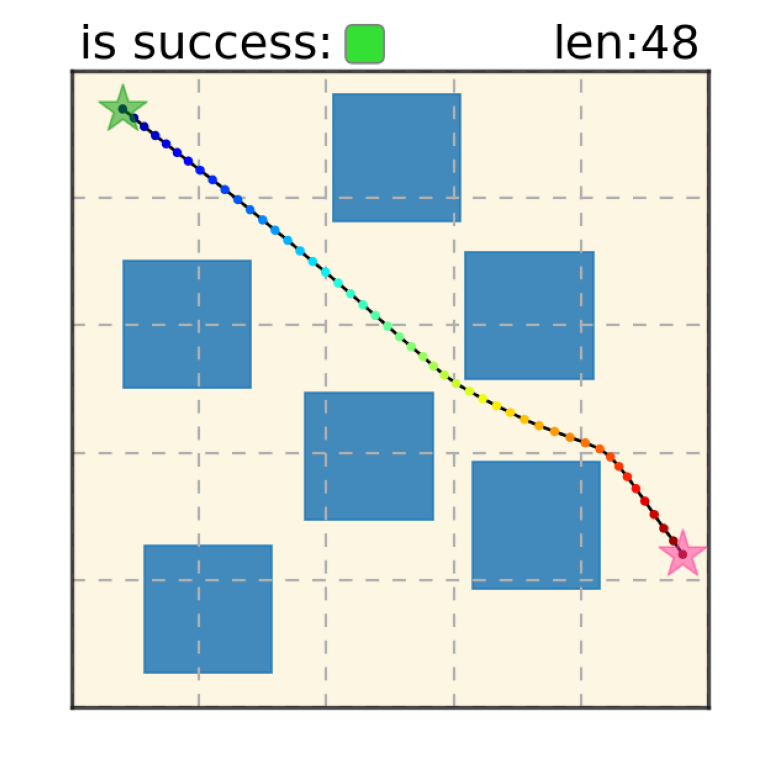

In [5]:
diffusion: GaussianDiffusionPB
bs = 1
policy = Policy(diffusion, train_normalizer, use_ddim=True)


## choose a start and goal position
start = np.array( [ [ 0.4, 4.7 ] ], dtype=np.float32 ).repeat( bs, 0 )
goal = np.array( [ [4.8, 1.2] ], dtype=np.float32  ).repeat( bs, 0 )

print( start.shape )
wloc_np = wloc # wloc in numpy

wloc_tensor = utils.to_torch(wloc_np).reshape(1, -1).repeat( (bs, 1) )
print( f'wloc_np: ', wloc_np.shape )

cond = {0: start, 
        47: goal}

samples = policy(cond, batch_size=-1, wall_locations=wloc_tensor, use_normed_wallLoc=use_normed_wallLoc, return_diffusion=True)

unnm_traj = samples[1].observations
print(f'unnm_traj: {unnm_traj.shape}')


root_dir = './visualization/'
print('traj shape:', unnm_traj.shape)
rd = RandStaticMazeRenderer(train_env_list)
tmp_path = f'{root_dir}/plot_rm2d_base.png'
img = rd.composite( tmp_path, unnm_traj,  np.array([env_id]))
img = imageio.imread(tmp_path)
utils.plt_img(img)

#### Another way of Rendering

In [ ]:
import imageio
from pb_diff_envs.environment.static.rand_maze2d_renderer import RandMaze2DRenderer


lemp_rd = RandMaze2DRenderer(num_walls_c=[len(wloc_np), 0], fig_dpi=300)
hExt = train_env_list.hExt_list[0, 0].tolist() # [0.5, 0.5]
hExts = np.array([hExt,] * len(wloc_np))

path_id = 9
img = lemp_rd.renders( unnm_traj[ path_id ], train_env_list.maze_size, wloc_np , hExts )
print(f'resol: {img.shape}')
tmp_path = f'./plot_rm2d_base.png'
# imageio.imsave( tmp_path, img )
utils.plt_img(img, dpi=120)


### create a denoising video

In [ ]:
from pb_diff_envs.environment.static.rand_maze2d_renderer import RandMaze2DRenderer
env = train_env_list.model_list[env_id]

traj_idx = 0 # which traj

x0_perstep = samples[3] # shape: B, n_steps, Horizon, Dim
x0_perstep.shape

n_steps = len(x0_perstep[0]) ## number of denosing steps + 1
trajs_ps = [] ## per-step trajs
imgs_ps = []

mz_renderer = RandMaze2DRenderer(num_walls_c=[30,10], fig_dpi=200)
mz_renderer.up_right = 'empty'
mz_renderer.config['no_draw_traj_line'] = False
mz_renderer.config['no_draw_col_info'] = True # False
# mz_renderer.num_walls_c = [0, 30]

for i_st in range(1, n_steps):
    traj_ps = x0_perstep[traj_idx][i_st] #
    trajs_ps.append(traj_ps)
    ### -----
    env_wlocs = env.wall_locations
    # hExt = plan_env_list.hExt_list[0, 0].tolist()
    # env_hExts = np.concatenate(env.hExt_list_c, axis=0)
    env_hExts = env.wall_hExts
    img = mz_renderer.renders( traj_ps , train_env_list.maze_size, env_wlocs, env_hExts )
    imgs_ps.append(img)

In [ ]:
## show the video
rootdir = './visualization/'
print('rootdir:', rootdir)
# import diffuser.utils.video as duv; reload(duv)
from diffuser.utils.video import save_images_to_mp4, read_mp4_to_numpy

mp4_name = f'{rootdir}/base_{env_id}.mp4' # {utils.get_time()}
## Save to video
save_images_to_mp4(imgs_ps, mp4_name, fps=15, st_sec=1, end_sec=1)
## load and save
import mediapy as media
from mediapy import show_video, read_video
show_video(read_mp4_to_numpy(mp4_name), fps=15, width=400)
print(f'mp4_name: {mp4_name}')